# Daily VWAP Price Analysis

This notebook extracts VWAP prices by product and day from Prosperity 1, 2, and 3 data. It creates a CSV with 10,000 rows (one for each timestamp in a day) and columns for each product-day combination.

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Part 1: Loading and Processing Data from All Prosperity Rounds

First, we'll define functions to load and process the price data from all Prosperity rounds.

In [29]:
# Define the data paths
prosperity1_datapath = "Prosperity 1 Data/"
prosperity2_datapath = "Prosperity 2 Data/"
prosperity3_datapath = "Prosperity 3 Data/"

def load_price_data(round_num, day_num, prosperity_round=1):
    """
    Load price data for a specific round and day.
    
    Parameters:
        round_num (int): Round number
        day_num (int): Day number
        prosperity_round (int): Prosperity round (1, 2, or 3)
        
    Returns:
        pd.DataFrame: DataFrame with price data
    """
    # Select the appropriate data path based on Prosperity round
    if prosperity_round == 1:
        datapath = prosperity1_datapath
        if round_num == 1:
            filepath = os.path.join(datapath, f"round-{round_num}-island-data-bottle/prices_round_{round_num}_day_{day_num}.csv")
        else:
            filepath = os.path.join(datapath, f"round-{round_num}-island-data-bottle/prices_round_{round_num}_day_{day_num}.csv")
    elif prosperity_round == 2:  # Prosperity round 2
        datapath = prosperity2_datapath
        if round_num == 1:
            filepath = os.path.join(datapath, f"round1data/prices_round_{round_num}_day_{day_num}.csv")
        else:
            filepath = os.path.join(datapath, f"round-{round_num}-island-data-bottle/prices_round_{round_num}_day_{day_num}.csv")
    else:  # Prosperity round 3
        datapath = prosperity3_datapath
        filepath = os.path.join(datapath, f"Round {round_num}/prices_round_{round_num}_day_{day_num}.csv")
    
    if not os.path.exists(filepath):
        print(f"Data file not found at {filepath}")
        return None
    
    # Load the data into a pandas DataFrame
    data = pd.read_csv(filepath, sep=';')
    
    # Add day information
    if 'day' in data.columns:
        # Use existing day column
        data['DAY'] = data['day']
    else:
        data['DAY'] = day_num
    
    # Add prosperity round information
    data['PROSPERITY_ROUND'] = prosperity_round
    data['ROUND'] = round_num
    
    return data

def load_all_price_data(round_num, prosperity_round=1):
    """
    Load all price data for a specific round.
    
    Parameters:
        round_num (int): Round number
        prosperity_round (int): Prosperity round (1, 2, or 3)
        
    Returns:
        pd.DataFrame: DataFrame with all price data
    """
    all_data = pd.DataFrame()
    
    for day_num in range(-2, 1):
        data = load_price_data(round_num, day_num, prosperity_round)
        if data is not None:
            # Add day offset to timestamp for continuity
            data['timestamp'] += np.power(10, 6) * (day_num+2)
            all_data = pd.concat([all_data, data])
    
    return all_data

In [30]:
def calculate_vwap(data, product):
    """
    Calculate the Volume-Weighted Average Price (VWAP) for a specific product.
    
    Parameters:
        data (pd.DataFrame): DataFrame with price data
        product (str): Product name
        
    Returns:
        pd.DataFrame: DataFrame with VWAP data for the product
    """
    # Check if the data has a 'product' column
    if 'product' in data.columns:
        # Filter for the specific product
        product_data = data[data['product'] == product].copy().fillna(0)
        if len(product_data) == 0:
            print(f"No data found for product {product}")
            return pd.DataFrame()
        
        # Check if mid_price is already in the dataframe
        if 'mid_price' not in product_data.columns:
            # Calculate mid price
            product_data['mid_price'] = (product_data['ask_price_1'] + product_data['bid_price_1']) / 2
        
        # Calculate volume - handle missing columns gracefully
        volume_cols = ['ask_volume_1', 'ask_volume_2', 'ask_volume_3', 'bid_volume_1', 'bid_volume_2', 'bid_volume_3']
        for col in volume_cols:
            if col not in product_data.columns:
                product_data[col] = 0
        
        product_data['volume'] = (
            product_data['ask_volume_1'] + product_data['ask_volume_2'] + product_data['ask_volume_3'] +
            product_data['bid_volume_1'] + product_data['bid_volume_2'] + product_data['bid_volume_3']
        )
        
        # Calculate dollar volume (price * volume) for each level
        dolvol = 0
        for i in range(1, 4):
            dolvol += product_data[f'ask_price_{i}'] * product_data[f'ask_volume_{i}']
            dolvol += product_data[f'bid_price_{i}'] * product_data[f'bid_volume_{i}']
        
        # Calculate VWAP
        product_data['price_volume'] = dolvol
        vwap = product_data.groupby('timestamp')['price_volume'].sum() / product_data.groupby('timestamp')['volume'].sum()
        
        # Add day information
        day_info = product_data.groupby('timestamp')['DAY'].first()
        round_info = product_data.groupby('timestamp')['ROUND'].first() if 'ROUND' in product_data.columns else None
        prosperity_round_info = product_data.groupby('timestamp')['PROSPERITY_ROUND'].first() if 'PROSPERITY_ROUND' in product_data.columns else None
        
        vwap_df = pd.DataFrame({'vwap': vwap, 'day': day_info})
        
        # Add round information if available
        if round_info is not None:
            vwap_df['round'] = round_info
        if prosperity_round_info is not None:
            vwap_df['prosperity_round'] = prosperity_round_info
        
        return vwap_df
    else:
        # Check if the product is a column in the dataframe
        if product in data.columns:
            # Create a dataframe with timestamp and product price
            product_data = pd.DataFrame({
                'timestamp': data['timestamp'],
                'price': data[product],
                'DAY': data['DAY'] if 'DAY' in data.columns else 0
            })
            
            # Add round information if available
            if 'ROUND' in data.columns:
                product_data['ROUND'] = data['ROUND']
            if 'PROSPERITY_ROUND' in data.columns:
                product_data['PROSPERITY_ROUND'] = data['PROSPERITY_ROUND']
            
            # Group by timestamp and calculate mean price
            vwap_df = pd.DataFrame({
                'vwap': product_data.groupby('timestamp')['price'].mean(),
                'day': product_data.groupby('timestamp')['DAY'].first()
            })
            
            # Add round information if available
            if 'ROUND' in product_data.columns:
                vwap_df['round'] = product_data.groupby('timestamp')['ROUND'].first()
            if 'PROSPERITY_ROUND' in product_data.columns:
                vwap_df['prosperity_round'] = product_data.groupby('timestamp')['PROSPERITY_ROUND'].first()
            
            return vwap_df
        else:
            print(f"Product {product} not found in data")
            return pd.DataFrame()

## Loading Data from All Prosperity Rounds

Let's load data from all Prosperity rounds and create a combined timestamp-level VWAP dataframe.

In [31]:
# Define the rounds to load for each Prosperity version
prosperity1_rounds = [1, 2, 3, 4, 5]
prosperity2_rounds = [1, 2, 3, 4, 5]
prosperity3_rounds = [1, 2, 3]

# Dictionary to store all loaded data
all_data = {}

# Load Prosperity 1 data
print("Loading Prosperity 1 data...")
for round_num in prosperity1_rounds:
    try:
        print(f"  Loading Round {round_num}...")
        data = load_all_price_data(round_num, prosperity_round=1)
        if len(data) > 0:
            all_data[f"P1_R{round_num}"] = data
            print(f"    Loaded {len(data)} rows of data")
            if 'product' in data.columns:
                products = data['product'].unique()
                print(f"    Products: {products}")
            else:
                products = [col for col in data.columns if col not in ['timestamp', 'DAY', 'ROUND', 'PROSPERITY_ROUND', 
                                                                       'TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 
                                                                       'SUNLIGHT', 'HUMIDITY']]
                print(f"    Products: {products}")
    except Exception as e:
        print(f"  Error loading Prosperity 1 Round {round_num}: {e}")

# Load Prosperity 2 data
print("\nLoading Prosperity 2 data...")
for round_num in prosperity2_rounds:
    try:
        print(f"  Loading Round {round_num}...")
        data = load_all_price_data(round_num, prosperity_round=2)
        if len(data) > 0:
            all_data[f"P2_R{round_num}"] = data
            print(f"    Loaded {len(data)} rows of data")
            if 'product' in data.columns:
                products = data['product'].unique()
                print(f"    Products: {products}")
            else:
                products = [col for col in data.columns if col not in ['timestamp', 'DAY', 'ROUND', 'PROSPERITY_ROUND', 
                                                                       'TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 
                                                                       'SUNLIGHT', 'HUMIDITY']]
                print(f"    Products: {products}")
    except Exception as e:
        print(f"  Error loading Prosperity 2 Round {round_num}: {e}")

# Load Prosperity 3 data
print("\nLoading Prosperity 3 data...")
for round_num in prosperity3_rounds:
    try:
        print(f"  Loading Round {round_num}...")
        data = load_all_price_data(round_num, prosperity_round=3)
        if len(data) > 0:
            all_data[f"P3_R{round_num}"] = data
            print(f"    Loaded {len(data)} rows of data")
            if 'product' in data.columns:
                products = data['product'].unique()
                print(f"    Products: {products}")
            else:
                products = [col for col in data.columns if col not in ['timestamp', 'DAY', 'ROUND', 'PROSPERITY_ROUND', 
                                                                       'TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 
                                                                       'SUNLIGHT', 'HUMIDITY']]
                print(f"    Products: {products}")
    except Exception as e:
        print(f"  Error loading Prosperity 3 Round {round_num}: {e}")

# Print summary of loaded data
print("\nSummary of loaded data:")
for key, data in all_data.items():
    print(f"  {key}: {len(data)} rows")

Loading Prosperity 1 data...
  Loading Round 1...
    Loaded 60000 rows of data
    Products: ['AMETHYSTS' 'STARFRUIT']
  Loading Round 2...
Data file not found at Prosperity 1 Data/round-2-island-data-bottle/prices_round_2_day_-2.csv
    Loaded 20002 rows of data
    Products: ['ORCHIDS']
  Loading Round 3...
Data file not found at Prosperity 1 Data/round-3-island-data-bottle/prices_round_3_day_-2.csv
Data file not found at Prosperity 1 Data/round-3-island-data-bottle/prices_round_3_day_-1.csv
    Loaded 40000 rows of data
    Products: ['CHOCOLATE' 'STRAWBERRIES' 'ROSES' 'GIFT_BASKET']
  Loading Round 4...
Data file not found at Prosperity 1 Data/round-4-island-data-bottle/prices_round_4_day_-2.csv
Data file not found at Prosperity 1 Data/round-4-island-data-bottle/prices_round_4_day_-1.csv
Data file not found at Prosperity 1 Data/round-4-island-data-bottle/prices_round_4_day_0.csv
  Loading Round 5...
Data file not found at Prosperity 1 Data/round-5-island-data-bottle/prices_round_5

## Calculate VWAP for All Products

In [32]:
# Dictionary to store all VWAP data
all_vwap = {}

# Process each dataset
for key, data in all_data.items():
    print(f"Processing {key}...")
    
    # Get products in this dataset
    if 'product' in data.columns:
        products = data['product'].unique()
        for product in products:
            print(f"  Calculating VWAP for {product}...")
            vwap_df = calculate_vwap(data, product)
            if not vwap_df.empty:
                product_key = f"{key}_{product}"
                all_vwap[product_key] = vwap_df
                print(f"    Calculated VWAP with {len(vwap_df)} data points")
            else:
                print(f"    No VWAP data for {product}")
    else:
        products = [col for col in data.columns if col not in ['timestamp', 'DAY', 'ROUND', 'PROSPERITY_ROUND', 
                                                               'TRANSPORT_FEES', 'EXPORT_TARIFF', 'IMPORT_TARIFF', 
                                                               'SUNLIGHT', 'HUMIDITY']]
        for product in products:
            print(f"  Calculating VWAP for {product}...")
            vwap_df = calculate_vwap(data, product)
            if not vwap_df.empty:
                product_key = f"{key}_{product}"
                all_vwap[product_key] = vwap_df
                print(f"    Calculated VWAP with {len(vwap_df)} data points")
            else:
                print(f"    No VWAP data for {product}")

# Print summary of VWAP data
print("\nSummary of VWAP data:")
for key, vwap_df in all_vwap.items():
    print(f"  {key}: {len(vwap_df)} data points")

Processing P1_R1...
  Calculating VWAP for AMETHYSTS...
    Calculated VWAP with 30000 data points
  Calculating VWAP for STARFRUIT...
    Calculated VWAP with 30000 data points
Processing P1_R2...
  Calculating VWAP for ORCHIDS...
    Calculated VWAP with 20001 data points
Processing P1_R3...
  Calculating VWAP for CHOCOLATE...
    Calculated VWAP with 10000 data points
  Calculating VWAP for STRAWBERRIES...
    Calculated VWAP with 10000 data points
  Calculating VWAP for ROSES...
    Calculated VWAP with 10000 data points
  Calculating VWAP for GIFT_BASKET...
    Calculated VWAP with 10000 data points
Processing P2_R1...
  Calculating VWAP for AMETHYSTS...
    Calculated VWAP with 30000 data points
  Calculating VWAP for STARFRUIT...
    Calculated VWAP with 30000 data points
Processing P2_R2...
  Calculating VWAP for ORCHIDS...
    Calculated VWAP with 20001 data points
Processing P2_R3...
  Calculating VWAP for CHOCOLATE...
    Calculated VWAP with 10000 data points
  Calculating 

## Creating Timestamp-Level VWAP Dataframe

Now let's create a timestamp-level VWAP dataframe with 10,000 rows (one for each timestamp in a day) and columns for each product-day combination.

In [33]:
# Create a timestamp-level VWAP dataframe
timestamp_vwap = {}

# Process each VWAP dataset
for key, vwap_df in all_vwap.items():
    print(f"Processing {key}...")
    
    # Extract product name from key
    parts = key.split('_')
    product = '_'.join(parts[2:])  # Handle products with underscores in name
    
    # For each day, create a column with product_d# naming
    for day in vwap_df['day'].unique():
        day_num = int(day) + 3  # Convert from -2,-1,0 to 1,2,3
        col_name = f"{product.lower()}_d{day_num}"
        
        # Get VWAP values for this product and day
        day_data = vwap_df[vwap_df['day'] == day]
        
        # Add to timestamp_vwap dictionary
        for ts, row in day_data.iterrows():
            if ts not in timestamp_vwap:
                timestamp_vwap[ts] = {}
            
            # If column already exists, take the average
            if col_name in timestamp_vwap[ts]:
                timestamp_vwap[ts][col_name] = (timestamp_vwap[ts][col_name] + row['vwap']) / 2
            else:
                timestamp_vwap[ts][col_name] = row['vwap']

# Convert the dictionary to a DataFrame
timestamp_vwap_df = pd.DataFrame.from_dict(timestamp_vwap, orient='index')

# Sort by timestamp
timestamp_vwap_df = timestamp_vwap_df.sort_index()

# Fill NaN values with forward fill, then backward fill
timestamp_vwap_df = timestamp_vwap_df.fillna(method='ffill').fillna(method='bfill')

# Print information about the dataframe
print(f"Created timestamp VWAP dataframe with {len(timestamp_vwap_df.columns)} columns")
print(f"Number of timestamps: {len(timestamp_vwap_df)}")

# Display the first few rows
timestamp_vwap_df.head()

Processing P1_R1_AMETHYSTS...
Processing P1_R1_STARFRUIT...
Processing P1_R2_ORCHIDS...
Processing P1_R3_CHOCOLATE...
Processing P1_R3_STRAWBERRIES...
Processing P1_R3_ROSES...
Processing P1_R3_GIFT_BASKET...
Processing P2_R1_AMETHYSTS...
Processing P2_R1_STARFRUIT...
Processing P2_R2_ORCHIDS...
Processing P2_R3_CHOCOLATE...
Processing P2_R3_STRAWBERRIES...
Processing P2_R3_ROSES...
Processing P2_R3_GIFT_BASKET...
Processing P3_R1_RAINFOREST_RESIN...
Processing P3_R1_KELP...
Processing P3_R1_SQUID_INK...
Processing P3_R2_CROISSANTS...
Processing P3_R2_JAMS...
Processing P3_R2_SQUID_INK...
Processing P3_R2_PICNIC_BASKET1...
Processing P3_R2_PICNIC_BASKET2...
Processing P3_R2_RAINFOREST_RESIN...
Processing P3_R2_DJEMBES...
Processing P3_R2_KELP...
Processing P3_R3_VOLCANIC_ROCK_VOUCHER_10500...
Processing P3_R3_DJEMBES...
Processing P3_R3_CROISSANTS...
Processing P3_R3_JAMS...
Processing P3_R3_VOLCANIC_ROCK_VOUCHER_10000...
Processing P3_R3_KELP...
Processing P3_R3_VOLCANIC_ROCK_VOUCHER_

C:\Users\fujos\AppData\Local\Temp\ipykernel_44408\425951603.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  timestamp_vwap_df = timestamp_vwap_df.fillna(method='ffill').fillna(method='bfill')


,amethysts_d1,starfruit_d1,rainforest_resin_d1,kelp_d1,squid_ink_d1,amethysts_d2,starfruit_d2,orchids_d2,rainforest_resin_d2,kelp_d2,squid_ink_d2,croissants_d2,jams_d2,picnic_basket1_d2,picnic_basket2_d2,djembes_d2,amethysts_d3,starfruit_d3,chocolate_d3,strawberries_d3,roses_d3,gift_basket_d3,rainforest_resin_d3,kelp_d3,squid_ink_d3,croissants_d3,jams_d3,picnic_basket1_d3,picnic_basket2_d3,djembes_d3,volcanic_rock_voucher_10500_d3,volcanic_rock_voucher_10000_d3,volcanic_rock_voucher_9750_d3,volcanic_rock_voucher_9500_d3,volcanic_rock_voucher_10250_d3,volcanic_rock_d3,orchids_d3
0,10000.000000,5000.000000,10000.000000,2000.000000,2000.000000,10000.031746,5043.52381,1200.0,9999.843459,2027.047619,2004.015873,4304.5,6670.5,59289.236842,30609.0,13450.5,9999.967213,5039.5,8000.0,4000.0,15000.0,71355.0,9999.991803,2030.0,1969.5,4321.5,6632.0,59228.5,30505.27907,13493.5,99.5,505.5,754.5,1003.5,273.5,10503.143902,1111.75
100,10000.000000,5000.156863,10000.000000,1999.882353,1999.274510,10000.031746,5043.52381,1200.0,9999.843459,2027.047619,2004.015873,4304.5,6670.5,59289.236842,30609.0,13450.5,9999.967213,5039.5,8000.0,4000.0,15000.0,71355.0,9999.991803,2030.0,1969.5,4321.5,6632.0,59228.5,30505.27907,13493.5,99.5,505.5,754.5,1003.5,273.5,10503.143902,1111.75
200,10000.000000,4999.516129,10000.000000,2000.016129,1998.983871,10000.031746,5043.52381,1200.0,9999.843459,2027.047619,2004.015873,4304.5,6670.5,59289.236842,30609.0,13450.5,9999.967213,5039.5,8000.0,4000.0,15000.0,71355.0,9999.991803,2030.0,1969.5,4321.5,6632.0,59228.5,30505.27907,13493.5,99.5,505.5,754.5,1003.5,273.5,10503.143902,1111.75
300,10000.000000,4999.500000,10000.000000,2000.500000,1998.500000,10000.031746,5043.52381,1200.0,9999.843459,2027.047619,2004.015873,4304.5,6670.5,59289.236842,30609.0,13450.5,9999.967213,5039.5,8000.0,4000.0,15000.0,71355.0,9999.991803,2030.0,1969.5,4321.5,6632.0,59228.5,30505.27907,13493.5,99.5,505.5,754.5,1003.5,273.5,10503.143902,1111.75
400,10000.230769,4998.500000,10000.230769,2000.500000,1998.000000,10000.031746,5043.52381,1200.0,9999.843459,2027.047619,2004.015873,4304.5,6670.5,59289.236842,30609.0,13450.5,9999.967213,5039.5,8000.0,4000.0,15000.0,71355.0,9999.991803,2030.0,1969.5,4321.5,6632.0,59228.5,30505.27907,13493.5,99.5,505.5,754.5,1003.5,273.5,10503.143902,1111.75


In [42]:
timestamp_vwap_df.columns

Index(['amethysts_d1', 'starfruit_d1', 'rainforest_resin_d1', 'kelp_d1', 'squid_ink_d1', 'amethysts_d2', 'starfruit_d2', 'orchids_d2', 'rainforest_resin_d2', 'kelp_d2', 'squid_ink_d2', 'croissants_d2', 'jams_d2', 'picnic_basket1_d2', 'picnic_basket2_d2', 'djembes_d2', 'amethysts_d3', 'starfruit_d3', 'chocolate_d3', 'strawberries_d3', 'roses_d3', 'gift_basket_d3', 'rainforest_resin_d3', 'kelp_d3', 'squid_ink_d3', 'croissants_d3', 'jams_d3', 'picnic_basket1_d3', 'picnic_basket2_d3', 'djembes_d3', 'volcanic_rock_voucher_10500_d3', 'volcanic_rock_voucher_10000_d3', 'volcanic_rock_voucher_9750_d3', 'volcanic_rock_voucher_9500_d3', 'volcanic_rock_voucher_10250_d3', 'volcanic_rock_d3', 'orchids_d3'], dtype='object')

High correlations (abs value >= 0.3):
                     Product 1                      Product 2  Correlation
                  amethysts_d1            rainforest_resin_d1     1.000000
 volcanic_rock_voucher_9500_d3               volcanic_rock_d3     0.988751
 volcanic_rock_voucher_9750_d3               volcanic_rock_d3     0.984043
 volcanic_rock_voucher_9750_d3  volcanic_rock_voucher_9500_d3     0.980031
volcanic_rock_voucher_10250_d3               volcanic_rock_d3     0.977615
 volcanic_rock_voucher_9500_d3 volcanic_rock_voucher_10250_d3     0.977226
 volcanic_rock_voucher_9750_d3 volcanic_rock_voucher_10250_d3     0.974367
                  amethysts_d2            rainforest_resin_d2     0.960688
volcanic_rock_voucher_10000_d3               volcanic_rock_d3     0.931568
volcanic_rock_voucher_10000_d3  volcanic_rock_voucher_9500_d3     0.930156
volcanic_rock_voucher_10000_d3  volcanic_rock_voucher_9750_d3     0.926352
volcanic_rock_voucher_10500_d3  volcanic_rock_voucher_9500_d3 

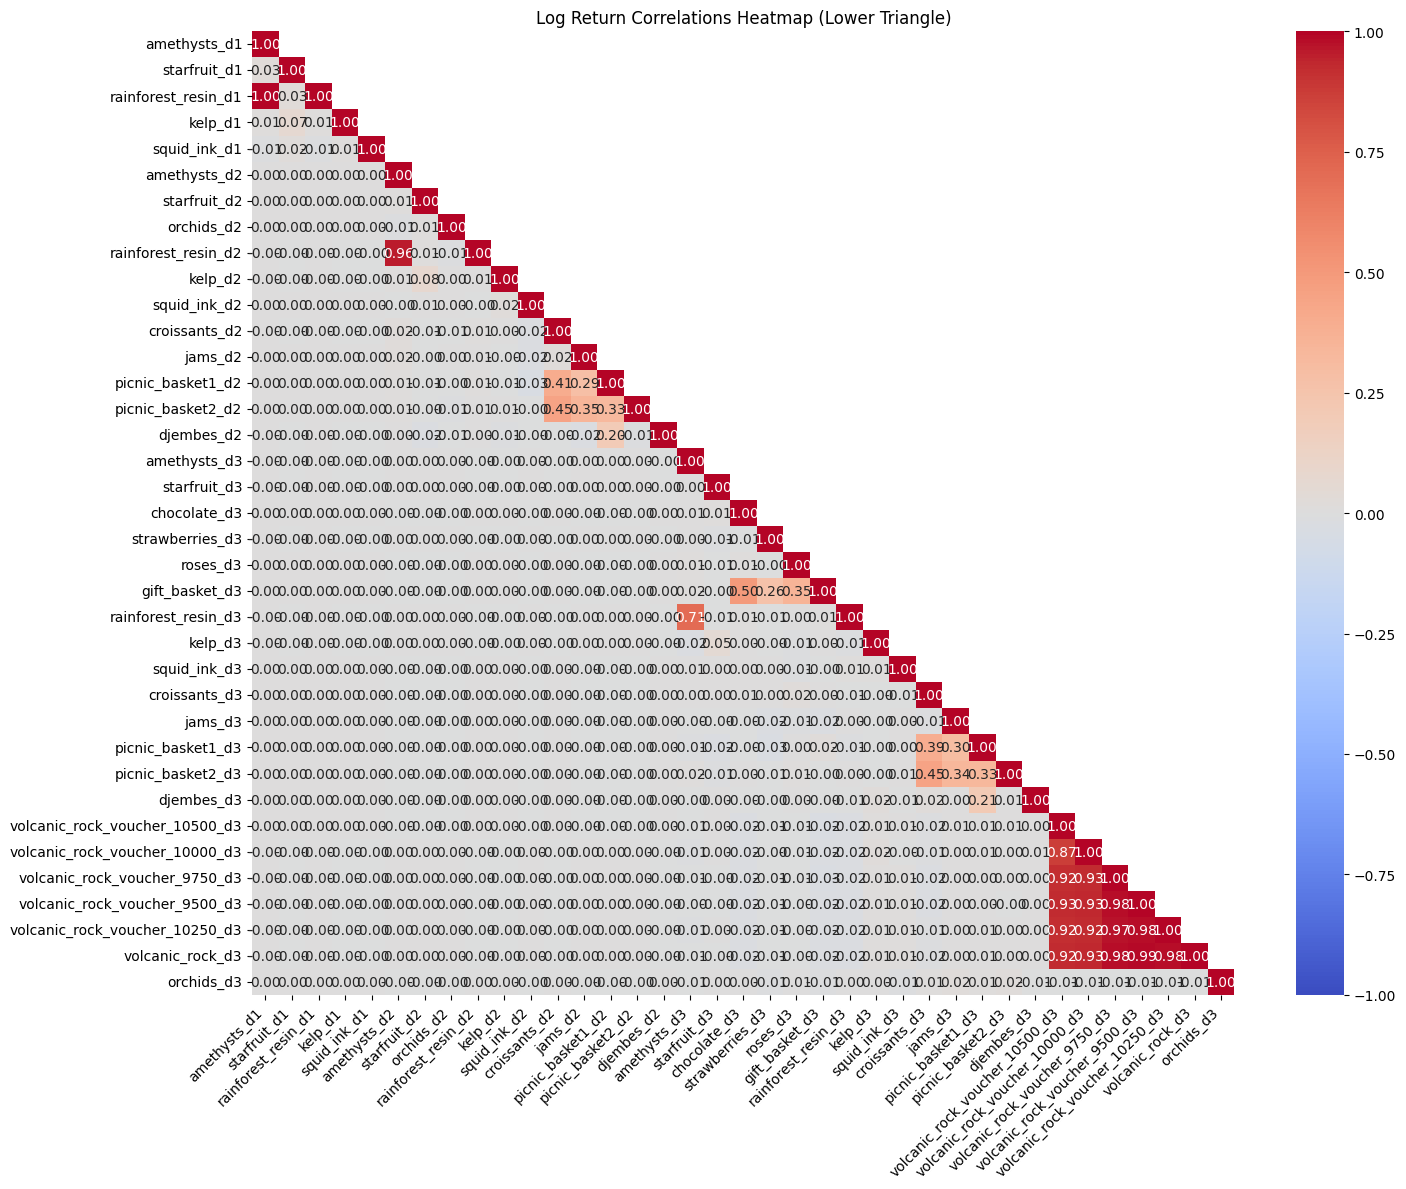

In [41]:
# Calculate correlation matrix of log returns
import seaborn as sns

corr_matrix = np.log(timestamp_vwap_df).diff().corr()

# Create a mask for correlations above threshold (excluding diagonal)
threshold = 0.3  # You can adjust this threshold
high_corr = pd.DataFrame()

# Get pairs of highly correlated columns
for i in range(len(timestamp_vwap_df.columns)):
    for j in range(i + 1, len(timestamp_vwap_df.columns)):  # Start from i+1 to avoid diagonal and duplicates
        correlation = corr_matrix.iloc[i, j]
        if abs(correlation) >= threshold:
            col1 = timestamp_vwap_df.columns[i]
            col2 = timestamp_vwap_df.columns[j]
            high_corr = pd.concat([high_corr, pd.DataFrame({
                'Product 1': [col1],
                'Product 2': [col2],
                'Correlation': [correlation]
            })])

# Sort by absolute correlation value
high_corr['Abs_Correlation'] = high_corr['Correlation'].abs()
high_corr = high_corr.sort_values('Abs_Correlation', ascending=False).drop('Abs_Correlation', axis=1)

# Display results
print(f"High correlations (abs value >= {threshold}):")
print(high_corr.to_string(index=False))

# Optional: Create a heatmap of high correlations
plt.figure(figsize=(15, 12))  # Larger figure size for better readability
mask = np.triu(np.ones_like(corr_matrix), k=1)  # Mask upper triangle including diagonal
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Log Return Correlations Heatmap (Lower Triangle)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Creating Daily VWAP Dataframe

Let's also create a daily VWAP dataframe for comparison.

In [34]:
# Create a daily VWAP dataframe
daily_vwap = {}

# Process each VWAP dataset
for key, vwap_df in all_vwap.items():
    # Extract product name from key
    parts = key.split('_')
    product = '_'.join(parts[2:])  # Handle products with underscores in name
    
    # Group by day and calculate mean VWAP
    daily_vwap_values = vwap_df.groupby('day')['vwap'].mean()
    
    # For each day, create a column with product_d# naming
    for day, vwap_value in daily_vwap_values.items():
        day_num = int(day) + 3  # Convert from -2,-1,0 to 1,2,3
        col_name = f"{product.lower()}_d{day_num}"
        
        # If column already exists, take the average
        if col_name in daily_vwap:
            daily_vwap[col_name] = (daily_vwap[col_name] + vwap_value) / 2
        else:
            daily_vwap[col_name] = vwap_value

# Convert the dictionary to a DataFrame
daily_vwap_df = pd.DataFrame([daily_vwap])

# Print information about the dataframe
print(f"Created daily VWAP dataframe with {len(daily_vwap_df.columns)} columns")

# Display the dataframe
daily_vwap_df

Created daily VWAP dataframe with 37 columns


,amethysts_d1,amethysts_d2,amethysts_d3,starfruit_d1,starfruit_d2,starfruit_d3,orchids_d2,orchids_d3,chocolate_d3,strawberries_d3,roses_d3,gift_basket_d3,rainforest_resin_d1,rainforest_resin_d2,rainforest_resin_d3,kelp_d1,kelp_d2,kelp_d3,squid_ink_d1,squid_ink_d2,squid_ink_d3,croissants_d2,croissants_d3,jams_d2,jams_d3,picnic_basket1_d2,picnic_basket1_d3,picnic_basket2_d2,picnic_basket2_d3,djembes_d2,djembes_d3,volcanic_rock_voucher_10500_d3,volcanic_rock_voucher_10000_d3,volcanic_rock_voucher_9750_d3,volcanic_rock_voucher_9500_d3,volcanic_rock_voucher_10250_d3,volcanic_rock_d3
0,9999.99356,9999.998926,10000.000282,5003.773822,5049.832103,5058.618438,1208.798933,1041.244125,8018.214758,4019.033882,14661.604855,71218.913464,9999.99356,9999.999252,9999.999959,2011.789765,2024.133704,2034.568796,2033.969462,1971.561966,1907.857357,4318.699497,4305.81584,6658.110306,6597.789864,59416.866978,59134.604326,30649.111379,30415.008091,13460.294015,13462.424067,72.610202,458.05687,704.879579,954.424029,229.912491,10454.095088


## Save Data to CSV

In [35]:
# Save the timestamp-level VWAP dataframe to CSV
timestamp_vwap_df.to_csv('prosperity_timestamp_vwap.csv')
print("Saved timestamp-level VWAP data to prosperity_timestamp_vwap.csv")

# Save the daily VWAP dataframe to CSV
daily_vwap_df.to_csv('prosperity_daily_vwap.csv', index=False)
print("Saved daily VWAP data to prosperity_daily_vwap.csv")

Saved timestamp-level VWAP data to prosperity_timestamp_vwap.csv
Saved daily VWAP data to prosperity_daily_vwap.csv
